In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/spam/spam"))

# Any results you write to the current directory are saved as output.

['williams-w3', 'BG', 'kitchen-l', 'spam', 'farmer-d', 'easy_ham', 'beck-s', 'SH', 'lokay-m', 'hard_ham', 'kaminski-v', 'GP']


In [2]:
# Load required libraries
import numpy as np
import pandas as pd
import os
import time
import pickle
import sys
sys.setrecursionlimit(1500)
import keras

from keras.layers import Input, Dense
from keras.models import Model,load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard

import sklearn
from sklearn import metrics
from sklearn import svm
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [3]:
def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

In [4]:
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('../input/spam/spam/spam',        SPAM),
    ('../input/spam/spam/easy_ham',    HAM),
    ('../input/spam/spam/hard_ham',    HAM),
    ('../input/spam/spam/beck-s',      HAM),
    ('../input/spam/spam/farmer-d',    HAM),
    ('../input/spam/spam/kaminski-v',  HAM),
    ('../input/spam/spam/kitchen-l',   HAM),
    ('../input/spam/spam/lokay-m',     HAM),
    ('../input/spam/spam/williams-w3', HAM),
    ('../input/spam/spam/BG',          SPAM),
    ('../input/spam/spam/GP',          SPAM),
    ('../input/spam/spam/SH',          SPAM)
]

SKIP_FILES = {'cmds'}
NEWLINE="\n"

def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'label': classification,'file':file_name})
        index.append(file_name)
   
    data_frame = pd.DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = pd.DataFrame({'text': [], 'label': [],'file':[]})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(np.random.permutation(data.index))
    return data

In [5]:
# We will load the Email spam dataset into Panadas dataframe here . 
data=load_data()

Percent: [##                                                ] 4%

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Percent: [##################################################] 100%

In [6]:
new_index=[x for x in range(len(data))]
data.index=new_index

In [7]:
def token_count(row):
    'returns token count'
    text=row['tokenized_text']
    length=len(text.split())
    return length

def tokenize(row):
    "tokenize the text using default space tokenizer"
    text=row['text']
    lines=(line for line in text.split(NEWLINE) )
    tokenized=""
    for sentence in lines:
        tokenized+= " ".join(tok for tok in sentence.split())
    return tokenized

In [8]:
data['tokenized_text']=data.apply(tokenize, axis=1)
data['token_count']=data.apply(token_count, axis=1)
data['lang']='en'
data.head()

,file,label,text,tokenized_text,token_count,lang
0,../input/spam/spam/GP/part10/msg2214.eml,spam,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...","<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",66,en
1,../input/spam/spam/GP/part12/msg4415.eml,spam,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...","<html><head><meta http-equiv=3D""Content-Langua...",52,en
2,../input/spam/spam/easy_ham/1051.cf81a19208b70...,ham,"Hi,\n\n\n\nOn Sun, 01 Sep 2002 00:05:03 MDT Re...","Hi,On Sun, 01 Sep 2002 00:05:03 MDT Reg Clemen...",106,en
3,../input/spam/spam/easy_ham/00051.c2215fd876c5...,ham,"On Tue, Aug 06, 2002 at 04:24:09PM +0100, Joe ...","On Tue, Aug 06, 2002 at 04:24:09PM +0100, Joe ...",100,en
4,../input/spam/spam/farmer-d/logistics/808,ham,"Just want to pat each of you on the back, and ...","Just want to pat each of you on the back, and ...",215,en


In [9]:
df=data
print("total emails : ", len(df))
print  ("total spam emails : ", len(df[df['label']=='spam']) )
print  ("total normal emails : ", len(df[df['label']=='ham']) )

total emails :  58910
total spam emails :  35371
total normal emails :  23539


In [10]:
# We randomize the rows to subset the dataframe
df.reset_index(inplace=True)
df=df.reindex(np.random.permutation(df.index))

In [11]:
len_unseen=10000
df_unseen_test= df.iloc[:len_unseen]
df_model = df.iloc[len_unseen:]

print('total emails for unseen test data : ', len(df_unseen_test))
print('\t total spam emails for enron  : ', len(df_unseen_test[(df_unseen_test['lang']=='en') & (df_unseen_test['label']=='spam')]))
print('\t total normal emails for enron  : ', len(df_unseen_test[(df_unseen_test['lang']=='en') & (df_unseen_test['label']=='ham')]))
print()

print('total emails for model training/validation : ', len(df_model))
print('\t total spam emails for enron  : ', len(df_model[(df_model['lang']=='en') & (df_model['label']=='spam')]))
print('\t total normal emails for enron  : ', len(df_model[(df_model['lang']=='en') & (df_model['label']=='ham')]))

total emails for unseen test data :  10000
	 total spam emails for enron  :  6029
	 total normal emails for enron  :  3971

total emails for model training/validation :  48910
	 total spam emails for enron  :  29342
	 total normal emails for enron  :  19568


In [12]:
# max number of features
num_max = 4000

In [13]:
def train_tf_idf_model(texts):
    "train tf idf model "
    tic = time.process_time()
    

    tok = Tokenizer(num_words=num_max)
    tok.fit_on_texts(texts)
    toc = time.process_time()

    print (" -----total Computation time = " + str((toc - tic)) + " seconds")
    return tok


def prepare_model_input(tfidf_model,dataframe,mode='tfidf'):
    
    "function to prepare data input features using tfidf model"
    tic = time.process_time()
    
    le = LabelEncoder()
    sample_texts = list(dataframe['tokenized_text'])
    sample_texts = [' '.join(x.split()) for x in sample_texts]
    
    targets=list(dataframe['label'])
    targets = [1. if x=='spam' else 0. for x in targets]
    sample_target = le.fit_transform(targets)
    
    if mode=='tfidf':
        sample_texts=tfidf_model.texts_to_matrix(sample_texts,mode='tfidf')
    else:
        sample_texts=tfidf_model.texts_to_matrix(sample_texts)
    
    toc = time.process_time()
    
    print('shape of labels: ', sample_target.shape)
    print('shape of data: ', sample_texts.shape)
    
    print (" -----total Computation time for preparing model data = " + str((toc - tic)) + " seconds")
    
    return sample_texts,sample_target

In [14]:
texts=list(df_model['tokenized_text'])
tfidf_model=train_tf_idf_model(texts)

 -----total Computation time = 26.268043741999996 seconds


In [15]:
# prepare model input data
mat_texts,tags=prepare_model_input(tfidf_model,df_model,mode='tfidf')

shape of labels:  (48910,)
shape of data:  (48910, 4000)
 -----total Computation time for preparing model data = 53.392766382999994 seconds


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(mat_texts, tags, test_size=0.15)
print ('train data shape: ', X_train.shape, y_train.shape)
print ('validation data shape :' , X_val.shape, y_val.shape)

train data shape:  (41573, 4000) (41573,)
validation data shape : (7337, 4000) (7337,)


In [21]:
## Define and initialize the network

model_save_path="../output/spam_detector_enron_model.h5"

In [35]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',keras.metrics.binary_accuracy])
    print('compile done')
    return model

def check_model(model,x,y,epochs=2):
    history=model.fit(x,y,batch_size=32,epochs=epochs,verbose=1,shuffle=True,validation_split=0.2,
              callbacks=[checkpointer, tensorboard]).history
    return history


def check_model2(model,x_train,y_train,x_val,y_val,epochs=10):
    history=model.fit(x_train,y_train,batch_size=64,
                      epochs=epochs,verbose=1,
                      shuffle=True,
                      validation_data=(x_val, y_val),
                      callbacks=[checkpointer, tensorboard]).history
    return history

# define checkpointer
checkpointer = ModelCheckpoint(filepath=model_save_path,
                               verbose=1,
                               save_best_only=True)    


# define tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)




# define the predict function for the deep learning model for later use
def predict(data):
    result=model.predict(data)
    prediction = [round(x[0]) for x in result]
    return prediction

In [22]:
# get the compiled model
model = get_simple_model()

# load history
# history=check_model(m,mat_texts,tags,epochs=10)
history=check_model2(model,X_train,y_train,X_val,y_val,epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               2048512   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 2,180,097
Trainable params: 2,180,097
Non-trainable params: 0
_________________________________________________________________
compile done
Train on 41573 samples, validate on 7337 samples
Epoch 1/10
41573/41573 [==============================] - 23s 551us/st

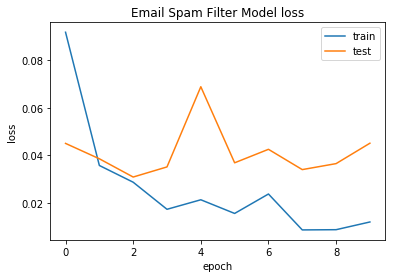

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [28]:
from IPython.display import FileLink, FileLinks
FileLinks('.') #lists all downloadable files on server

./
  model.h5
  spam_detector_enron_model.h5
  __notebook_source__.ipynb
./logs/
  events.out.tfevents.1558172463.275775fc40bc
  events.out.tfevents.1558171752.275775fc40bc

In [45]:
test_data = pd.DataFrame()
test_data['text']= data['text'][0]

In [46]:
test_data['tokenized_text']=test_data.apply(tokenize, axis=1)
test_data['token_count']=test_data.apply(token_count, axis=1)
test_data['lang']='en'
test_data.head()

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [39]:
predict(data[:1])

ValueError: Error when checking input: expected dense_4_input to have shape (4000,) but got array with shape (7,)